# INF 264 - Project 2: Digit recognizer

## Introduction

In this project we will be using different classifiers to classify handwritten digits from the MNIST handwritten digits database. We will be evaluating the different classifiers by testing how well they perform on unseen data and selecting the best model based on the performance on validation data. Finally we will see how well the best model generalizes by seeing how well it performs on testing data.

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

## Helper functions

In [2]:
#Function to plot the distribution of labels and printing the number of each label
def plot_distribution(labels):
    #Plots the histogram
    plt.hist(labels, bins=np.arange(12)-0.5, color='blue', edgecolor='black')
    plt.xticks(np.arange(0, 11, 1))
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

    #List to store the label counts
    label_counts = []

    #Calculate the label count for each label
    for i in range(11):
        label_count = np.sum(labels == i)
        label_counts.append(label_count)

    #Print the label counts as well as the percentage of the total
    for i in range(11):
        print("Label {}: {} ({:.2f}%)".format(i, label_counts[i], label_counts[i]/len(labels)*100))


#Function to plot a confusion matrix
def plot_confusion_matrix(y_val, y_pred, title):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Loading in and exploring the data

In this section we will load in the data and explore it a bit. We want to see how the data is structured, what the value ranges are, the label distribution as well as if there are any null values or duplicate values in the data.

In [3]:
#read in MNIST-images.npy and MNIST-labels.npy 
#These files needs to be in the same directory as the notebook
images = np.load('MNIST-images.npy')
labels = np.load('MNIST-labels.npy')

#First lets print the shape of the images and labels
print("Shape of images: ", images.shape)
print("Shape of labels: ", labels.shape)

Shape of images:  (85273, 24, 24, 1)
Shape of labels:  (85273,)


We can see that there are a total of 85273 images and labels where each image is a 24x24 array. Next let's look at the value range

In [4]:
#Let's see what the range of values are
print("Range of values in images: ", np.min(images), "to", np.max(images))
print("Range of values in labels: ", np.min(labels), "to", np.max(labels))

Range of values in images:  0 to 255
Range of values in labels:  0 to 10


We can see that the values range from 0 to 10 where 10 means "not a number". Each image has a value from 0 to 255. These are greyscalevalues where 0 means white and 255 means black.

In [5]:
#Let's see if there are any null values in the dataset
print("Dataset contains null values: ", np.any(np.isnan(images)))

Dataset contains null values:  False


It looks like our dataset is complete, which means we don't have to account for null values by imputing values.

In [6]:
#See how many duplicate images there are
print("Number of duplicate images: ", len(images) - len(np.unique(images, axis=0)))

Number of duplicate images:  0


It also seems that all the images are unique. Next we will have a look at the first few images.

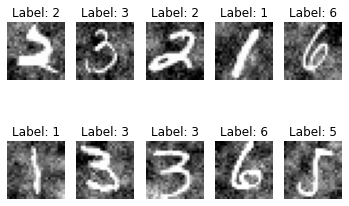

In [7]:
#Plot the first 10 images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')

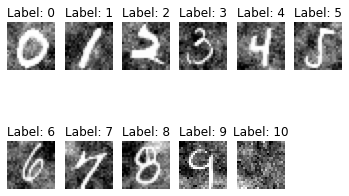

In [8]:
#Next let's look at all the different numbers
for i in range(11):
    plt.subplot(2, 6, i+1)
    plt.imshow(images[labels == i][0], cmap='gray')
    plt.title('Label: {}'.format(labels[labels == i][0]))
    plt.axis('off')

It is worth noting that there is quite a bit of noise in the background. Let's try to reduce this noise by setting all pixels less than a threshold to 0 and all pixels above the threshold to 255.

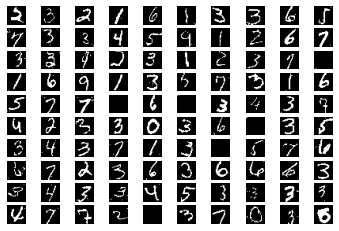

In [9]:
#Remove background noise from the images by setting all values less than 200 to 0 (black) and all values greater than 200 to 1 (white)
threshold = 200
images[images < threshold] = 0
images[images >= threshold] = 1

#Plot the first 100 images
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

We experimented with different values for the threshold and inspected the numbers for each one. In the end we used 200 as a threshold as this seemed to work well.

Also note that we set the values below the threshold to 0 and above the threshold to 1.

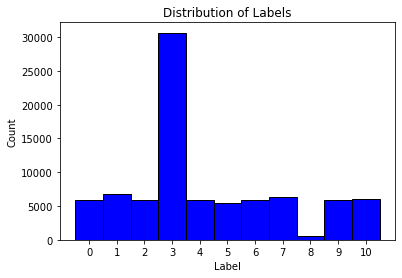

Label 0: 5923 (6.95%)
Label 1: 6742 (7.91%)
Label 2: 5958 (6.99%)
Label 3: 30655 (35.95%)
Label 4: 5842 (6.85%)
Label 5: 5421 (6.36%)
Label 6: 5918 (6.94%)
Label 7: 6265 (7.35%)
Label 8: 600 (0.70%)
Label 9: 5949 (6.98%)
Label 10: 6000 (7.04%)


In [10]:
#Next let's look at the distribution of labels in the dataset
plot_distribution(labels)

We can see there is a large imbalance in the data. Let's fix this with resampling techniques after splitting the data

## Splitting the data

In [11]:
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Here we have used 80% of the data as training data and 20% for testing. Let's have a quick look at the distribution of the training data.

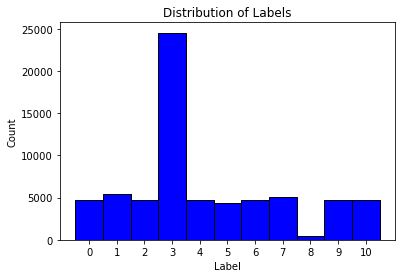

Label 0: 4729 (6.93%)
Label 1: 5457 (8.00%)
Label 2: 4740 (6.95%)
Label 3: 24543 (35.98%)
Label 4: 4671 (6.85%)
Label 5: 4313 (6.32%)
Label 6: 4750 (6.96%)
Label 7: 5048 (7.40%)
Label 8: 480 (0.70%)
Label 9: 4732 (6.94%)
Label 10: 4755 (6.97%)


In [12]:
plot_distribution(y_train)

we can see that the training data is imbalanced with very many three's and few eight's. So let's try to fix this now.

## Undersampling the three's
In this section we will select a random subset of the three's to use as our training data, and we will discard the rest. As discussed earlier this means we will lose a lot of information, but hopefully the performance will be better.

In [13]:
#Create a list of indexes where the label is 3 in the training set 
index_list = np.where(y_train == 3)[0]

#Set seed for reproducibility
np.random.seed(42)

#We will remove 70% of the images with label 3 from the training set
remove_n = int(0.7 * len(index_list))

#Select  random indexes
random_indexes = np.random.choice(index_list, remove_n, replace=False)

#Remove the random indexes from the index list
X_train_undersample = np.delete(X_train, random_indexes, axis=0)
y_train_undersample = np.delete(y_train, random_indexes, axis=0)

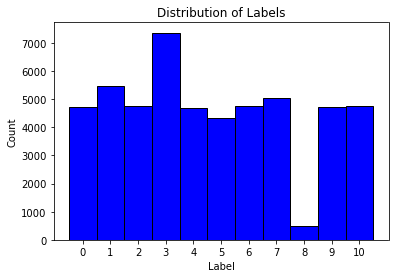

Label 0: 4729 (9.27%)
Label 1: 5457 (10.69%)
Label 2: 4740 (9.29%)
Label 3: 7363 (14.43%)
Label 4: 4671 (9.15%)
Label 5: 4313 (8.45%)
Label 6: 4750 (9.31%)
Label 7: 5048 (9.89%)
Label 8: 480 (0.94%)
Label 9: 4732 (9.27%)
Label 10: 4755 (9.32%)


In [14]:
#Let's see what the distribution of labels is now
plot_distribution(y_train_undersample)

## Oversampling

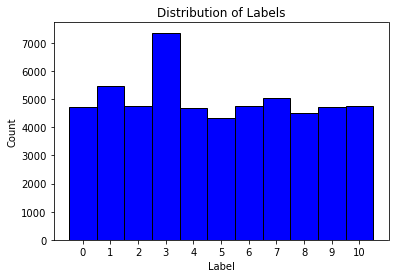

Label 0: 4729 (8.59%)
Label 1: 5457 (9.91%)
Label 2: 4740 (8.61%)
Label 3: 7363 (13.37%)
Label 4: 4671 (8.48%)
Label 5: 4313 (7.83%)
Label 6: 4750 (8.63%)
Label 7: 5048 (9.17%)
Label 8: 4500 (8.17%)
Label 9: 4732 (8.59%)
Label 10: 4755 (8.64%)


In [15]:
#Oversample the rows with label 8
strategy = {8: 4500}
oversample = SMOTE(random_state=42, sampling_strategy=strategy)

#Flatten the data
X_train_undersample_flat = X_train_undersample.reshape(X_train_undersample.shape[0], -1)

X_train_resample, y_train_resample = oversample.fit_resample(X_train_undersample_flat, y_train_undersample)

plot_distribution(y_train_resample)

Let's now take a look at some of the synthetically generated eight's

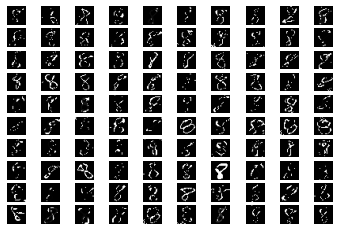

In [16]:
#Find rows in X_train_resample that have label 8
index_list = np.where(y_train_resample == 8)[0]

#Find rows in X_train that have label 8
index_list_original = np.where(y_train_undersample == 8)[0]

#Find all the indices in index_list that are not in index_list_original
index_list = np.setdiff1d(index_list, index_list_original)

# Plot the first 100 images from index list
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_train_resample[index_list[i]].reshape(24, 24), cmap='gray')
    plt.axis('off')

We can see that most of the eight's does not look good. We can do this in another way instead.
A nice property about eight's is that they are both horizontally and vertically symmetric. This means we can get more samples by flipping the eight's horizontally/vertically/both.

In [17]:
#Get all eight's from X_train_undersample and y_train_undersample
X_train_undersample_8 = X_train_undersample[y_train_undersample == 8]

#For each image in X_train_undersample_8, flip the image array horizontally
X_train_undersample_8_flipped_horizontally = np.array([np.fliplr(image) for image in X_train_undersample_8])

#For each image in X_train_undersample_8, flip the image array vertically
X_train_undersample_8_flipped_vertically = np.array([np.flipud(image) for image in X_train_undersample_8])

#For each image in X_train_undersample_8, flip the image array horizontally and vertically
X_train_undersample_8_flipped_both = np.array([np.flipud(image) for image in X_train_undersample_8_flipped_horizontally])

Let's quickly check that we did this properly

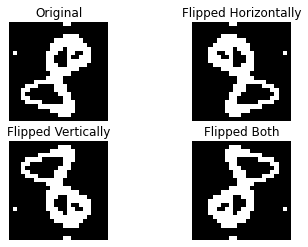

In [18]:
#Plot the first image
plt.subplot(2, 2, 1)
plt.imshow(X_train_undersample_8[0], cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(X_train_undersample_8_flipped_horizontally[0], cmap='gray')
plt.title('Flipped Horizontally')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(X_train_undersample_8_flipped_vertically[0], cmap='gray')
plt.title('Flipped Vertically')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(X_train_undersample_8_flipped_both[0], cmap='gray')
plt.title('Flipped Both')
plt.axis('off')
plt.show()

This looks correct

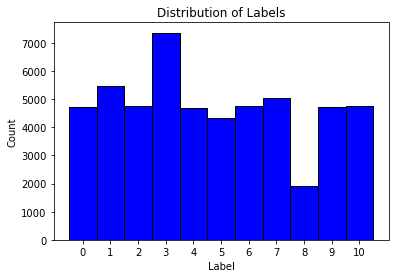

Label 0: 4729 (9.01%)
Label 1: 5457 (10.40%)
Label 2: 4740 (9.03%)
Label 3: 7363 (14.03%)
Label 4: 4671 (8.90%)
Label 5: 4313 (8.22%)
Label 6: 4750 (9.05%)
Label 7: 5048 (9.62%)
Label 8: 1920 (3.66%)
Label 9: 4732 (9.02%)
Label 10: 4755 (9.06%)


In [19]:
#Add the flipped images to the training set
X_train_resample = np.concatenate((X_train_undersample, X_train_undersample_8_flipped_horizontally, X_train_undersample_8_flipped_vertically, X_train_undersample_8_flipped_both), axis=0)

#Add the labels to the training set
y_train_undersample_8 = y_train_undersample[y_train_undersample == 8]
y_train_resample = np.concatenate((y_train_undersample, y_train_undersample_8, y_train_undersample_8, y_train_undersample_8), axis=0)

#Let's see what the distribution of labels is now
plot_distribution(y_train_resample)

## Dropping resampling

At this point we realized that we cannot use resampling because we are using cross-validation for our model selection. This means the modifications we did in the training data will leak into the validation data. Thus we have decided to move on with the original training data set.

## Baseline models
In this section we will look at a couple of baseline models which we will try to beat with a better performing model later. For these models we will use holdout validation to measure accuracy. Thus, we need to use part of the training data for validation data.

### Majority class classifier
This classifier always predicts the majority label

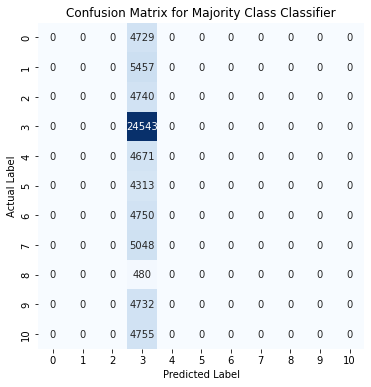

Accuracy:  0.35977308041865785


In [20]:
#Majority class classifier
y_pred = np.full(y_train.shape, np.argmax(np.bincount(y_train)))

#Plot the confusion matrix for the majority class classifier
plot_confusion_matrix(y_train, y_pred, 'Confusion Matrix for Majority Class Classifier')

#Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)

#Print accuracy
print("Accuracy: ", accuracy)

We see that we get an accuracy of 0.3597 which is as expected after looking at the label distribution from earlier. This is not a very good accuracy.

### Random label classifier
This classifier will predict a random label each time

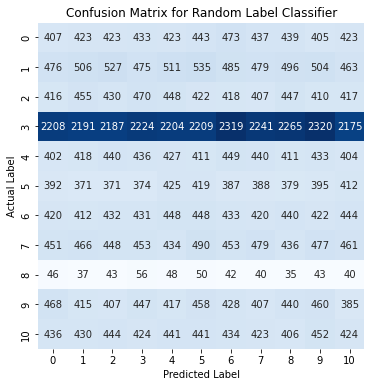

Accuracy:  0.09153009469641443


In [21]:
#Random label classifier

#Set seed for reproducibility
np.random.seed(42)
y_pred = np.random.randint(0, 11, y_train.shape)

#Plot the confusion matrix for the random label classifier
plot_confusion_matrix(y_train, y_pred, 'Confusion Matrix for Random Label Classifier')

#Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)

#Print the accuracy
print("Accuracy: ", accuracy)


We can see that we got an even worse accuracy of only 0.0915. After looking at these baseline models we know we should at least try to get a better accuracy than 0.3597.

## Random forest classifier

In [22]:
%%time

#Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

#Grid search to find the best parameters
rfc_gridSearch = GridSearchCV(rfc, {'n_estimators': [10, 100, 1000], 'criterion': ['gini', 'entropy']}, scoring='accuracy', n_jobs=-1)

#Reshape the data to be 2D
X_train_resample = X_train_resample.reshape(X_train.shape[0], -1)

#Train the model
rfc_gridSearch.fit(X_train, y_train)

#Let's save the model in a list
models = [rfc_gridSearch]

/Users/sigurdblakkestad/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 1min 36s, sys: 1.05 s, total: 1min 37s
Wall time: 6min 35s


In [23]:
#Create table with the results of the grid search
results = pd.DataFrame(rfc_gridSearch.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results.columns = ['n_estimators', 'criterion', 'mean_validation_accuracy']
results = results.sort_values(by='mean_validation_accuracy', ascending=False)
results

,n_estimators,criterion,mean_validation_accuracy
2,1000,gini,0.939041
5,1000,entropy,0.934163
1,100,gini,0.933343
4,100,entropy,0.930161
0,10,gini,0.885952
3,10,entropy,0.884409


/Users/sigurdblakkestad/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


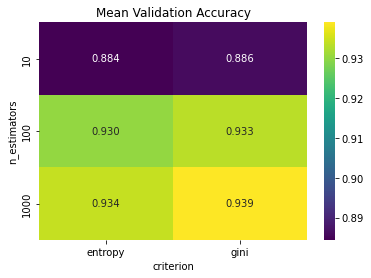

In [24]:
#Visualize the results of the grid search using a heatmap of the mean test score for each combination of parameters 
results = results.pivot('n_estimators', 'criterion', 'mean_validation_accuracy')
sns.heatmap(results, annot=True, fmt='.3f', cmap='viridis')
plt.title('Mean Validation Accuracy')
plt.show()

Already we can see we get a much better accuracy than the baseline model. However, we still have a lot of room for improvement. After looking at the confusion matrix we can see that the model predicts a lot of three's. This is also where the model make the most amount of mistakes. We can for example see that in 188 cases the model predicted a 3, but the true label was 8. And it only predicted eight 11 times when the true label was eight. This is does not come as a surprise as we have not yet done anything to deal with the data imbalance. We will do this later. But next let's try to use a support vector machine classifier.

## Support vector machine classifier

In [25]:
#Svm classifier
svm = svm.SVC(random_state=42)
svm_gridSearch = GridSearchCV(svm, {'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}, scoring='accuracy', n_jobs=-1)
svm_gridSearch.fit(X_train, y_train)
models.append(svm_gridSearch)

In [26]:
#Create table with the results of the grid search with no index column
results = pd.DataFrame(svm_gridSearch.cv_results_)
results = results[['param_gamma', 'param_kernel', 'mean_test_score']]
results.columns = ['gamma', 'kernel', 'mean_validation_accuracy']
results = results.sort_values(by='mean_validation_accuracy', ascending=False)
results

,gamma,kernel,mean_validation_accuracy
1,scale,rbf,0.957792
3,auto,rbf,0.891898
0,scale,linear,0.868821
2,auto,linear,0.868821


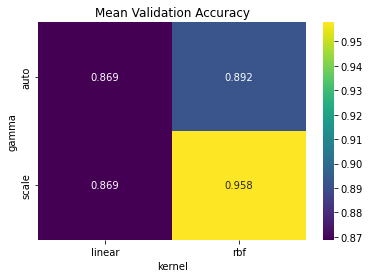

In [27]:
#Visualize the results of the grid search using a heatmap of the mean test score for each combination of parameters
results = results.pivot('gamma', 'kernel', 'mean_validation_accuracy')
sns.heatmap(results, annot=True, fmt='.3f', cmap='viridis')
plt.title('Mean Validation Accuracy')
plt.show()

## MLPClassifier

In [28]:
#MLP Classifier
mlp = MLPClassifier(random_state=42, activation='relu')
mlp_gridSearch = GridSearchCV(mlp, {'hidden_layer_sizes': [(100,), (500,), (150, 100, 50)], 'learning_rate_init': [0.01, 0.001, 0.0001], }, scoring='accuracy', n_jobs=-1)
mlp_gridSearch.fit(X_train, y_train)
models.append(mlp_gridSearch)

In [29]:
#Create table with the results of the grid search
results = pd.DataFrame(mlp_gridSearch.cv_results_)
results = results[['param_hidden_layer_sizes', 'param_learning_rate_init', 'mean_test_score']]
results.columns = ['hidden_layer_sizes', 'learning_rate_init', 'mean_validation_accuracy']
results = results.sort_values(by='mean_validation_accuracy', ascending=False)
results

,hidden_layer_sizes,learning_rate_init,mean_validation_accuracy
5,"(500,)",0.001,0.966805
8,"(150, 100, 50)",0.001,0.961336
4,"(500,)",0.01,0.960726
7,"(150, 100, 50)",0.01,0.957906
1,"(100,)",0.01,0.956420
2,"(100,)",0.001,0.956172
3,"(500,)",0.1,0.857769
0,"(100,)",0.1,0.850432
6,"(150, 100, 50)",0.1,0.327817


/Users/sigurdblakkestad/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


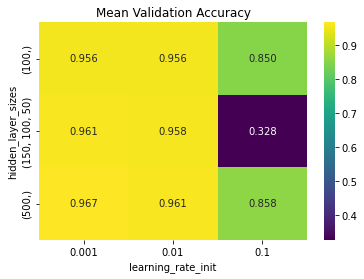

In [30]:
#Visualize the results of the grid search using a heatmap of the mean test score for each combination of parameters
results = results.pivot('hidden_layer_sizes', 'learning_rate_init', 'mean_validation_accuracy')
sns.heatmap(results, annot=True, fmt='.3f', cmap='viridis')
plt.title('Mean Validation Accuracy')
plt.show()

## Selecting the best model

In [31]:
#Find the best model based on the best accuracy score
best_model = models[np.argmax([model.best_score_ for model in models])]

#Print the best model
print("The best model: ")
print(best_model.best_estimator_)
print("Hyperparameters: ", best_model.best_params_)
print("Validation accuracy: ", best_model.best_score_)


The best model: 
MLPClassifier(hidden_layer_sizes=(500,), random_state=42)
Hyperparameters:  {'hidden_layer_sizes': (500,), 'learning_rate_init': 0.001}
Validation accuracy:  0.966805176898988


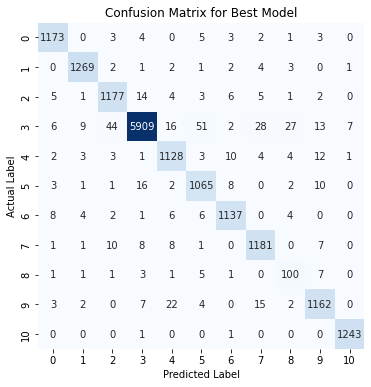

Test accuracy:  0.9700381119906186


In [32]:
#Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test.reshape(X_test.shape[0], -1))
plot_confusion_matrix(y_test, y_test_pred, 'Confusion Matrix for Best Model')
accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy: ", accuracy)